In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib

In [2]:
df = pd.read_csv("./data/definitivo.csv")
df.reset_index(drop=True, inplace=True)
df.info()
pd.set_option('display.float_format', '{:.2f}'.format) # Para mostrar los numeros completos sin anotacion cientifica

## El modelo definitivo ha sido ***GradientBoosting + XGboost***:
- #### **SIN HIPERPARÁMETROS**,
- #### **CON NORMALIZACIÓN**,
- #### **QUITANDO** las columnas: ***'piscina', 'ascensor', 'reformado'***,
- #### **CON PESOS [0.2, 1]** para los modelos
- #### **SIN OUTLIERS**, sólo entre 0 y 1M de euros

## ***Las métricas han sido:***
- #### **MAE**: 57174.55626981096
- #### **MAPE**: 0.3293120920224783
- #### **RMSE**: 79853.99354053184
- #### **R2**: 0.8041115846455356

## **Con base en la estadistica del target**:

- ### **MAE (57,174.55)**: El modelo, en promedio, **tiene un error absoluto de alrededor de 57,174 euros** al predecir el precio de una vivienda. Dado que el precio **promedio** de una vivienda **es de 264,474.43 euros**, esto **equivale a un error absoluto promedio de 21.6%** del valor medio.

- ### **MAPE (0.3293)**: El modelo tiene un **error porcentual promedio del 32.99% respecto al valor real.** Esto puede ser más relevante para viviendas más económicas, donde el impacto del error relativo es mayor.

- ### **MSE (79,853.99)**: Es una **métrica más sensible** a los grandes errores (outliers). En comparación con el rango de precios (mínimo de 11,800 y máximo de 950,000), este valor indica que **el modelo puede manejar tanto valores altos como bajos con un error razonable.**

- ### **R2 (0.8041)**: El modelo **explica el 80.41% de la variabilidad en los precios** de las viviendas. Esto indica un **buen ajuste, pero aún hay margen de mejora** en la captura de ciertas variabilidades (quizás por factores no considerados).

### **Las features (variables) más importantes** para el modelo son las siguientes, ordenadas de mayor a menor:
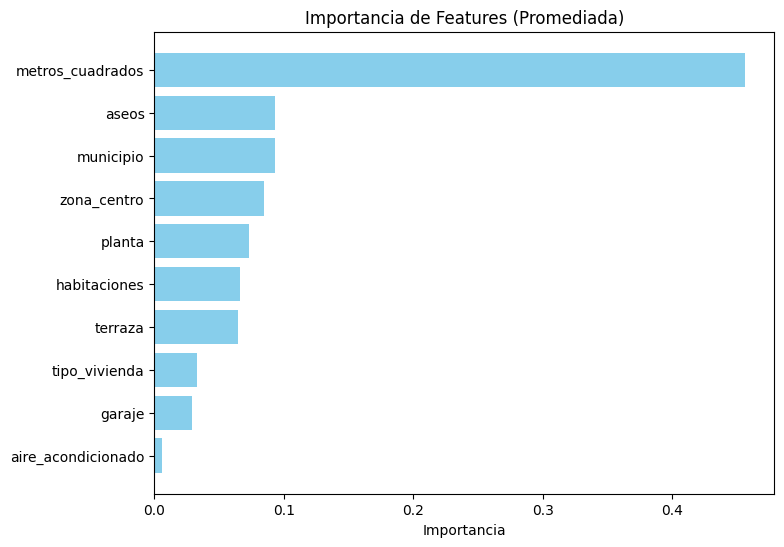

## **Cargamos el modelo**.

In [14]:
# Carga el modelo desde el archivo
mi_modelo = joblib.load("Gradient_XGB_model.pkl")
print("¡Modelo cargado correctamente!")
print(type(mi_modelo)) 
print(mi_modelo.get_params()["estimators"])

¡Modelo cargado correctamente!
<class 'sklearn.ensemble._voting.VotingRegressor'>
[('gbr', GradientBoostingRegressor(random_state=42)), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...))]


## **Lo ponemos a prueba** introduciendo datos inventados o nuevos de una vivienda **para obtener una tasación**.

### Para ello es importante **cargar los mapeos, codificaciones** que se usaron en *featuring_enginnering.ipynb* y **el escalador (normalización)**. Después **aplicar dicha codificación** correspondiente tanto para ***las que se le aplicaron codificación*** en su momento como para ***las que ya eran binarias***.

### ***La siguiente función se encarga de todo ello***, tan sólo ha de pasarse los datos de la nueva vivienda.

In [11]:
def codificacion_y_escalado(nueva_vivienda):
    import joblib
    import numpy as np

    # Cargar los mapeos y encoders
    mapeos = joblib.load("mapeos.pkl")
    label_encoders = joblib.load("label_encoders.pkl")
    scaler = joblib.load("scaler_voting.pkl")  # Cargar el scaler

    print("-----> Mapeos cargados:") # Mostrar los mapeos
    for columna, mapping in mapeos.items():
        print(f"\n'{columna}': {mapping}")

    print("\n-----> Encoders cargados:",list(label_encoders.keys()))  # Lista de columnas codificadas

    # Las columnas que se codificaron como categóricas
    categoricas = ['municipio', 'tipo_vivienda', 'garaje']  

    # Diccionario de mapeo para columnas binarias
    binary_mappings = {
        'zona_centro': {'Sí': 1, 'No': 0},
        'terraza': {'Sí': 1, 'No': 0},
        'aire_acondicionado': {'Sí': 1, 'No': 0}
    }

    # Aplica el mapeo a las columnas binarias
    for col, mapping in binary_mappings.items():
        if col in nueva_vivienda.columns:
            nueva_vivienda[col] = nueva_vivienda[col].map(mapping)

    # Verifica si alguna columna tiene valores no mapeados en las columnas binarias
    if nueva_vivienda[list(binary_mappings.keys())].isnull().any().any():
        raise ValueError("Algunos valores en columnas binarias no pudieron mapearse. Verifica las entradas del usuario.")

    # Aplica la codificación usando los encoders cargados para columnas categóricas
    for col in categoricas:
        if col in nueva_vivienda.columns:
            le = label_encoders[col]  # Recupera el encoder para la columna
            if 'Otro' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'Otro')  # Añade 'Otro' como clase si no está

            # Verifica si el valor está en las clases conocidas, si no, lo clasifica como 'Otro'
            nueva_vivienda[col] = nueva_vivienda[col].apply(
                lambda x: x if x in le.classes_ else 'Otro'
            )
            # Transforma los valores categóricos a numéricos
            nueva_vivienda[col] = le.transform(nueva_vivienda[col])

    print("\n-----> Nueva vivienda codificada:")
    print(nueva_vivienda)

    # Aplica el escalado usando el scaler cargado
    columnas_ordenadas = scaler.feature_names_in_  # Asegura que las columnas estén en el orden correcto
    nueva_vivienda = nueva_vivienda[columnas_ordenadas]  # Ordena las columnas según el scaler
    nueva_vivienda_escalada = scaler.transform(nueva_vivienda)

    print("\n-----> Nueva vivienda escalada:")
    print(nueva_vivienda_escalada)

    return nueva_vivienda_escalada  # Devuelve el DataFrame escalado

### ***Y en esta función se realiza la predicción*** del precio de la vivienda despues de ser codificada. **Se calcula el intervalo de error estimado para la predicción utilizando las métricas de evaluación** de tu modelo, como el **MAE** (Error Absoluto Medio) y el **MAPE** (Error Absoluto Porcentual Medio)

In [12]:
def prediccion_con_intervalo(modelo, nueva_vivienda, mae, mape):
    # Realiza la predicción
    prediccion = modelo.predict(nueva_vivienda)[0]
    
    # Calcula el intervalo basado en MAE
    intervalo_mae = (prediccion - mae, prediccion + mae)
    
    # Calcula el intervalo basado en MAPE
    intervalo_mape = (prediccion * (1 - mape), prediccion * (1 + mape))
    
    # Imprime resultados
    print(f"Predicción estimada: {prediccion:,.2f} euros")
    print(f"Intervalo basado en MAE: ({intervalo_mae[0]:,.2f} - {intervalo_mae[1]:,.2f}) euros")
    print(f"Intervalo basado en MAPE: ({intervalo_mape[0]:,.2f} - {intervalo_mape[1]:,.2f}) euros")

### Creamos una nueva vivienda y le aplicamos la **codificación**

In [13]:
nueva_vivienda = pd.DataFrame({
    'municipio': ['Valencia'],
    'tipo_vivienda': ['Piso'],
    'habitaciones': [3],
    'metros_cuadrados': [110],
    'aseos': [1],
    'planta': [7],
    'garaje': ['No'],
    'zona_centro': ['Sí'],
    'terraza': ['Sí'],
    'aire_acondicionado': ['Sí']
})

# Codificación
nueva_vivienda_codificada = codificacion_y_escalado(nueva_vivienda)

-----> Mapeos cargados:

'municipio': {'Aldaia': np.int64(0), 'Manises': np.int64(1), 'Otro': np.int64(2), 'Paterna': np.int64(3), 'Quart de Poblet': np.int64(4), 'Riba-Roja de Túria': np.int64(5)}

'tipo_vivienda': {'Casa': np.int64(0), 'Casa adosada': np.int64(1), 'Chalet': np.int64(2), 'Estudio': np.int64(3), 'Finca': np.int64(4), 'Piso': np.int64(5), 'Planta baja': np.int64(6)}

'garaje': {'No': np.int64(0), 'Sí': np.int64(1)}

-----> Encoders cargados: ['municipio', 'tipo_vivienda', 'garaje']

-----> Nueva vivienda codificada:
   municipio  tipo_vivienda  habitaciones  metros_cuadrados  aseos  planta  \
0          2              5             3               110      1       7   

   garaje  zona_centro  terraza  aire_acondicionado  
0       0            1        1                   1  

-----> Nueva vivienda escalada:
[[ 0.25033199  0.77165537 -0.31077347 -0.42589759 -1.33576371  2.62962987
  -0.47392677  1.79933981  2.74954542 10.29563014]]


### Realizamos la **predicción junto con las métricas de evaluación** obtenidas en el modelo.

In [14]:
mae = 57174.55  # MAE de mi modelo
mape = 0.32931   # MAPE de mi modelo

# Predicción usando el modelo y la vivienda codificada
precio = prediccion_con_intervalo(mi_modelo, nueva_vivienda_codificada, mae, mape)

Predicción estimada: 277,408.08 euros
Intervalo basado en MAE: (220,233.53 - 334,582.63) euros
Intervalo basado en MAPE: (186,054.83 - 368,761.34) euros
